<a href="https://colab.research.google.com/github/charlieh0tel/ddf_analysis/blob/main/DopplerAnalysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
%pip install quantities
import numpy as np
import quantities as pq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 3.3 MB/s eta 0:00:00


In [3]:
import shutil
import tempfile
import urllib
import scipy.io.wavfile

def ReadWAVFromURL(url):
  with urllib.request.urlopen(url) as response:
    with tempfile.NamedTemporaryFile(delete=True) as tmp_file:
      shutil.copyfileobj(response, tmp_file)
      return scipy.io.wavfile.read(tmp_file.name)

In [13]:
n_antennas = 4
dwell_time = 156. * pq.us
rotation_period = n_antennas * dwell_time
rotation_frequency = (1. / rotation_period).rescale(pq.kHz)
print(f"{rotation_period:f} = {rotation_frequency:f}")

624.000000 us = 1.602564 kHz


In [4]:
URL = 'https://github.com/charlieh0tel/ddf_analysis/raw/main/Wouxun_KG-UV3D_10ft_away_16kbps_stereo_440.800_test3.wav'

sample_rate, samples = ReadWAVFromURL(URL)

left = samples[:, 0]
right = samples[:, 1]
print(f"sample_rate={sample_rate} [Hz], samples={len(samples)}, time={len(samples) / sample_rate} [s]")
print(f"samples={samples}")
print(f"left={left}")
print(f"right={right}")

sample_rate=48000 [Hz], samples=2035215, time=42.4003125 [s]
samples=[[19048 -1981]
 [20507 -2275]
 [21315 -1381]
 ...
 [12289 -2395]
 [ 8895 -1226]
 [ 5144 -2803]]
left=[19048 20507 21315 ... 12289  8895  5144]
right=[-1981 -2275 -1381 ... -2395 -1226 -2803]


In [5]:
def plot_audio(time_sec,n_samples,signal,filtered=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (msec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1000,signal[:n_samples],'y-',label='Audio signal')
    if filtered is not None:
        plt.plot(time_sec[:n_samples]*1000,filtered[:n_samples],'g-',label='Filtered signal')
    plt.legend()

In [29]:
# Start later in the file
time_offset = 1.41
start = int(time_offset * sample_rate)
left = left[start:]
right = right[start:]

720


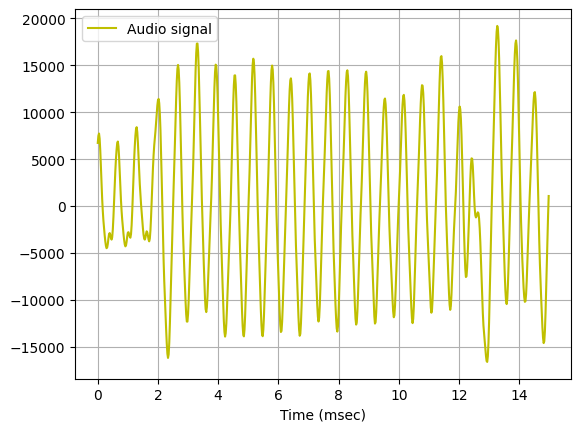

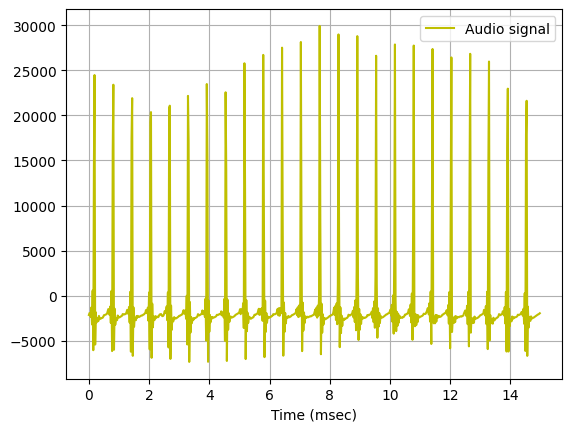

In [30]:
T = 15e-3
n = int(T * sample_rate)
print(n)
tvec = np.linspace(0, T, n, endpoint=False)
plot_audio(tvec, n, left)
plot_audio(tvec, n, right)

In [31]:
from scipy.signal import lfiltic, lfilter, firwin

class fir_filter(object):
    def __init__(self, coeffs):
        self.coeffs = coeffs
        self.zl = lfiltic(self.coeffs, 32768.0, [], [])
    def __call__(self, data):
        result, self.zl = lfilter(self.coeffs, 32768.0, data, -1, self.zl)
        return result

[   0    0    0    0    2    5   11   18   26   36   46   54   61   63
   61   52   37   15  -12  -46  -85 -126 -167 -206 -239 -264 -278 -279
 -264 -233 -186 -123  -47   39  132  229  322  409  482  538  572  580
  561  514  440  340  218   79  -70 -224 -375 -515 -637 -734 -801 -833
 -828 -785 -705 -591 -447 -280  -97   93  282  460  620  753  853  914
  935  914  853  753  620  460  282   93  -97 -280 -447 -591 -705 -785
 -828 -833 -801 -734 -637 -515 -375 -224  -70   79  218  340  440  514
  561  580  572  538  482  409  322  229  132   39  -47 -123 -186 -233
 -264 -279 -278 -264 -239 -206 -167 -126  -85  -46  -12   15   37   52
   61   63   61   54   46   36   26   18   11    5    2    0    0    0
    0]


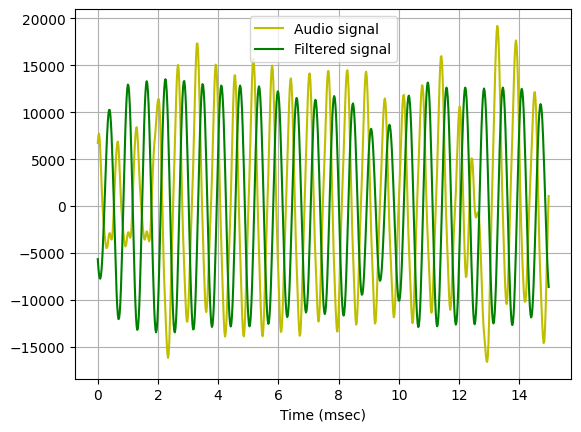

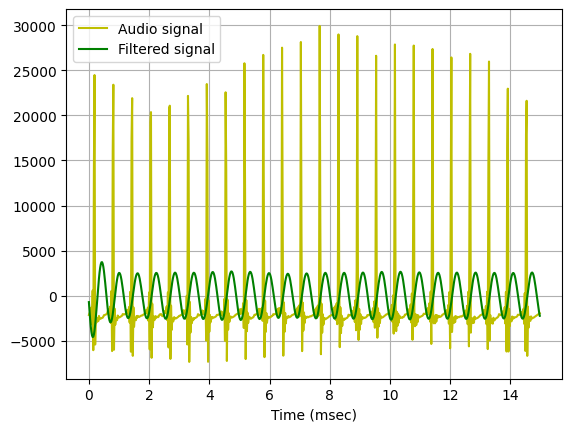

In [32]:
fcenter = rotation_frequency.rescale(pq.Hz).magnitude
width = 5.0  
ntaps = 141
bpf_coeffs = np.array(
    firwin(ntaps,
           [(fcenter - width) / (sample_rate / 2), (fcenter + width) / (sample_rate / 2)],
           width = None, pass_zero = False, scale = True, 
           window='hann') * 32768, dtype=int)

print(bpf_coeffs)

bpf = fir_filter(bpf_coeffs)

filter_delay = len(bpf_coeffs) // 2

delay = 12

samples = n + filter_delay + delay
left_audio_samples = left[ntaps - 1:ntaps - 1 + samples]
left_filtered_audio = bpf(left_audio_samples)[filter_delay:]
plot_audio(tvec,n,left,left_filtered_audio)

right_audio_samples = right[ntaps - 1:ntaps - 1 + samples]
right_filtered_audio = bpf(right_audio_samples)[filter_delay:]
plot_audio(tvec,n,right,right_filtered_audio)